In [15]:
import googlemaps
from datetime import datetime, date, time
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
import pickle
import json
import collections
import seaborn as sns
from statistics import mean

In [2]:
# import origin and destination data
file_path = '../Data/'
output_file_path = file_path + 'Output/'

origins = pd.read_csv(file_path + 'origins_gdf.csv')
destinations = pd.read_csv(file_path + 'destinations_gdf.csv')

In [3]:
# transform into geo dataframe
origins['geometry'] = origins['geometry'].apply(wkt.loads)
destinations['geometry'] = destinations['geometry'].apply(wkt.loads)
origins = gpd.GeoDataFrame(origins, geometry='geometry')
destinations = gpd.GeoDataFrame(destinations, geometry='geometry')

In [4]:
with open(file_path + 'config.json') as config:
    api_key = json.load(config)['api_key']
gmaps = googlemaps.Client(key=api_key)

In [5]:
# extract origin and destination coordinates from the GeoDataFrames
point_origins = origins.geometry.apply(lambda point: (point.y, point.x)).tolist()
point_destinations = destinations.geometry.apply(lambda point: (point.y, point.x)).tolist()

In [8]:
od_pair_count = min(len(point_origins), len(point_destinations))
sample_duration = {}

In [16]:
traffic_models = ['durations', 'best_guess', 'pessimistic', 'optimistic']


def get_traffic_time_with_models(sample_date: datetime.date, start_hour=0, end_hour=23):
    durations = {model: collections.defaultdict(list) for model in traffic_models}

    for day_hour in range(start_hour, end_hour + 1):
        # note: `distance_matrix` will convert to the current system timezone. colab timezone is UTC
        # import time, time.tzname to check your timezone
        dep_time = datetime.combine(sample_date, time(day_hour, 0))

        for origin, destination in zip(point_origins, point_destinations):
            # get 'duration' and 'durations_in_traffic' from gmaps.distance_matrix. 
            duration_res_list = []
            for model in traffic_models[1:]:
                result = gmaps.distance_matrix(origins=origin, destinations=destination, mode='driving',
                                               departure_time=dep_time, traffic_model=model)
                duration_res = result['rows'][0]['elements'][0]['duration']['value']
                duration_res_list.append(duration_res)

                durations_in_traffic_res = result['rows'][0]['elements'][0]['duration_in_traffic']['value']
                durations[model][day_hour].append(durations_in_traffic_res)

            # check duration is the same among three different traffic model requests.
            if len(set(duration_res_list)) != 1:
                print(f'duration not equal: {dep_time, origin, destination}')
            durations['durations'][day_hour].append(mean(duration_res_list))
    return durations

In [10]:
sample_weekday = date(2023, 10, 18)
weekday_durations = get_traffic_time_with_models(sample_date=sample_weekday)
sample_duration[sample_weekday] = weekday_durations

<Axes: >

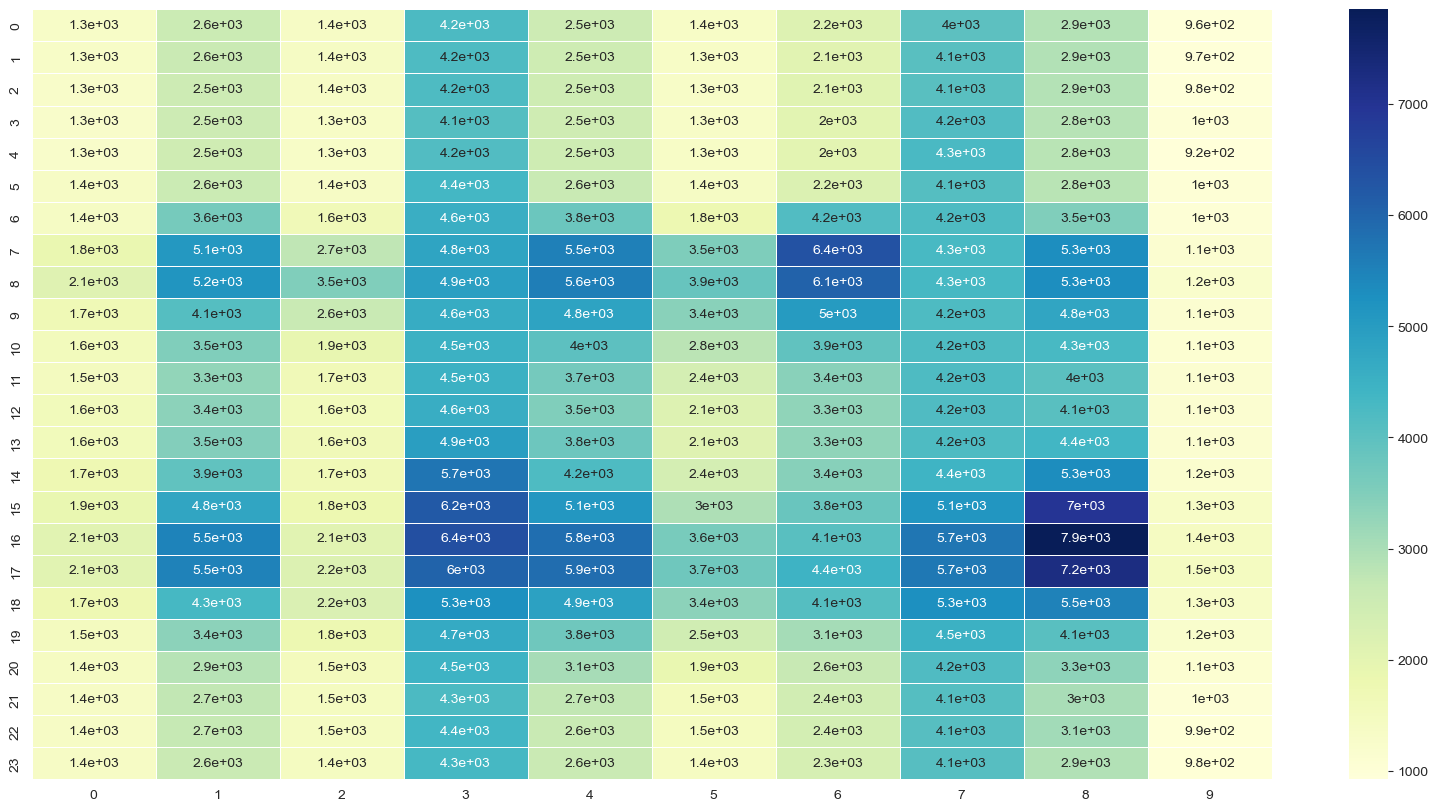

In [11]:
# visualize the travel time hot spot of different times of the day
traffic_heatmap_weekday = pd.DataFrame.from_dict(weekday_durations['best_guess'], orient='index')
plt.figure(figsize=(20, 10))
sns.heatmap(traffic_heatmap_weekday, annot=True, cmap='YlGnBu', linewidths=.5)

In [12]:
sample_weekend = date(2023, 10, 21)
weekend_duration = get_traffic_time_with_models(sample_date=date(2023, 10, 21))
sample_duration[sample_weekend] = weekend_duration

duration not equal: (datetime.datetime(2023, 10, 21, 21, 0), (33.73247904045904, -118.3071916244818), (34.18182136334436, -118.27657401374343))
duration not equal: (datetime.datetime(2023, 10, 21, 22, 0), (33.73247904045904, -118.3071916244818), (34.18182136334436, -118.27657401374343))


<Axes: >

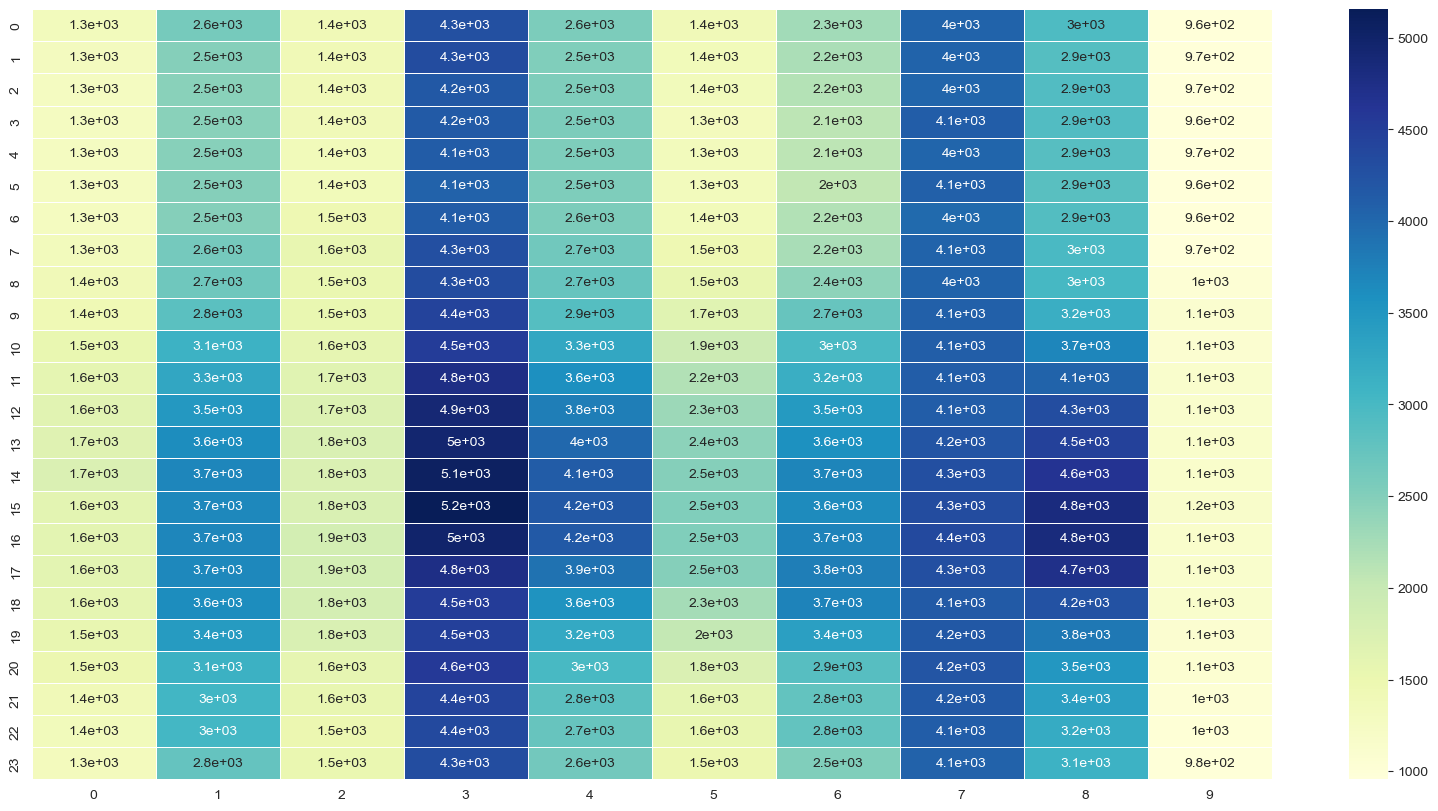

In [13]:
traffic_heatmap_weekend = pd.DataFrame.from_dict(weekend_duration['best_guess'], orient='index')
plt.figure(figsize=(20, 10))
sns.heatmap(traffic_heatmap_weekend, annot=True, cmap='YlGnBu', linewidths=.5)

In [26]:
# save the results.

for date in sample_duration:
    for model in traffic_models:
        file_name = output_file_path + date.strftime('%Y%m%d') + '_' + model + '.csv'
        pd.DataFrame.from_dict(sample_duration[date][model], orient='index').to_csv(file_name)

# Visualization

In [64]:
# draw function
def draw_travel_time_with_different_models(df: pd.DataFrame, add_title=''):
    for od_pair_index in range(od_pair_count):
        fig = plt.figure()
        plt.xticks(range(24))
        ax = sns.lineplot(x='day_hour', y='duration', hue='traffic_model', data=df[df['od_pair'] == od_pair_index])
        ax.set_ylabel("travel time (minute)")
        ax.set_xlabel("time of day")
        ax.set_title(f'OD Pair {od_pair_index}' + add_title)

## Visualization of different google api duration in traffic models

In [27]:
sample_duration_df = pd.DataFrame(
    [(date, model, day_hour, od_pair, duration) for date in sample_duration for model in traffic_models for
     day_hour, res in sample_duration[date][model].items() for od_pair, duration in enumerate(res)],
    columns=['date', 'traffic_model', 'day_hour', 'od_pair', 'duration'])
sample_duration_df

,date,traffic_model,day_hour,od_pair,duration
0,2023-10-18,durations,0,0,1496.0
1,2023-10-18,durations,0,1,3104.0
2,2023-10-18,durations,0,2,1594.0
3,2023-10-18,durations,0,3,4791.0
4,2023-10-18,durations,0,4,2939.0
...,...,...,...,...,...
1915,2023-10-21,optimistic,23,5,1366.0
1916,2023-10-21,optimistic,23,6,2199.0
1917,2023-10-21,optimistic,23,7,3878.0
1918,2023-10-21,optimistic,23,8,2918.0


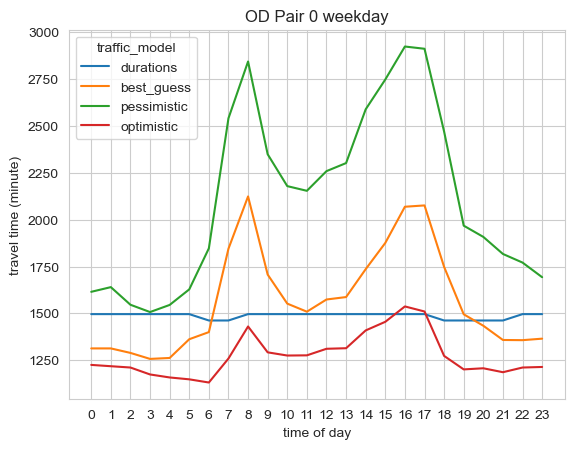

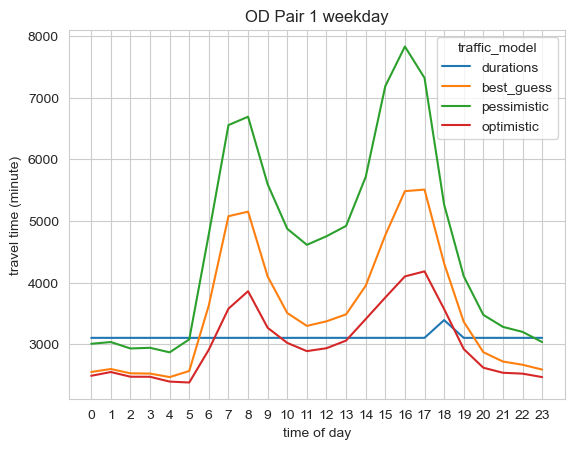

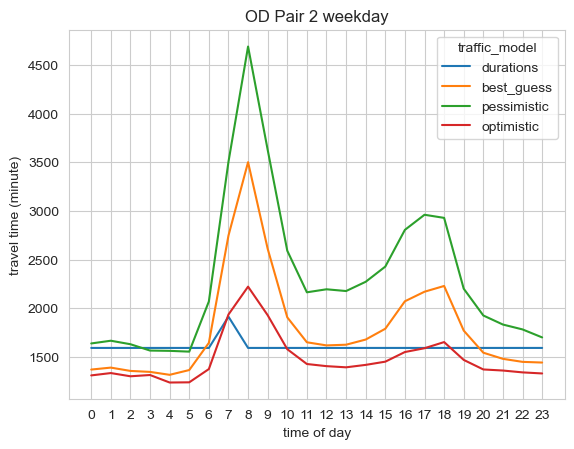

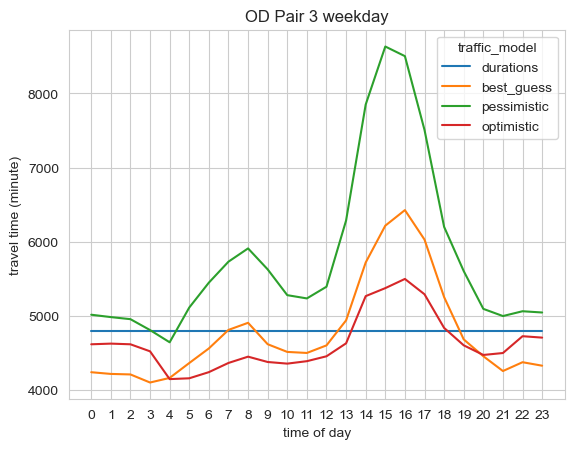

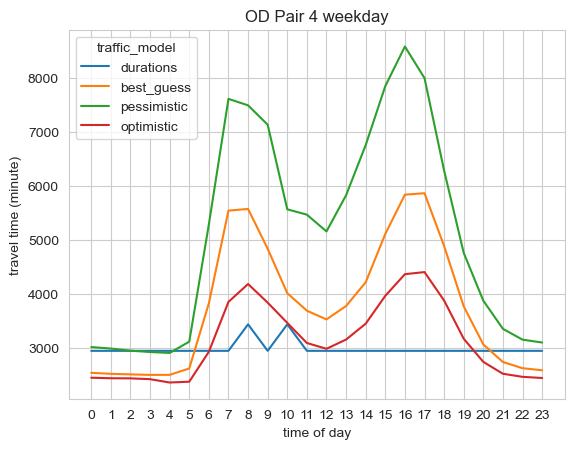

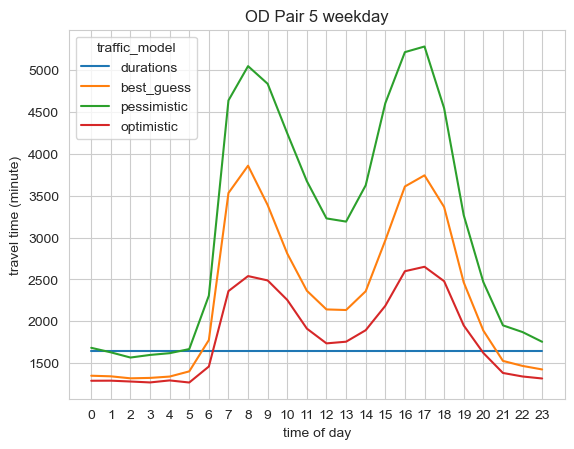

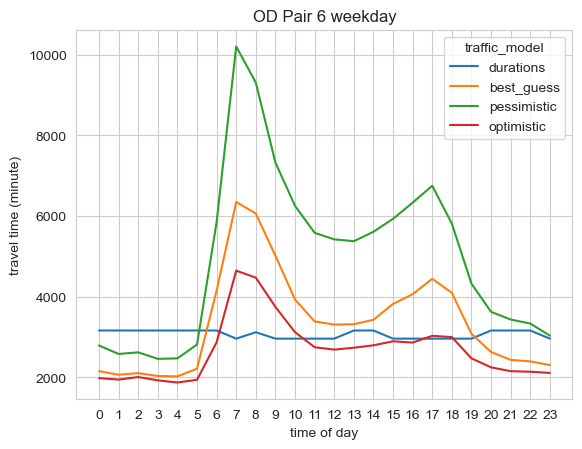

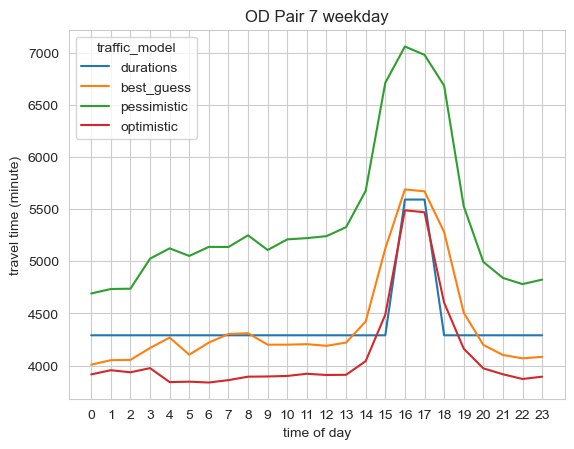

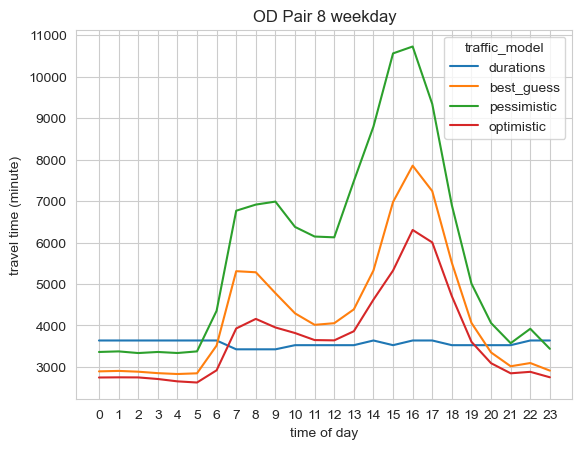

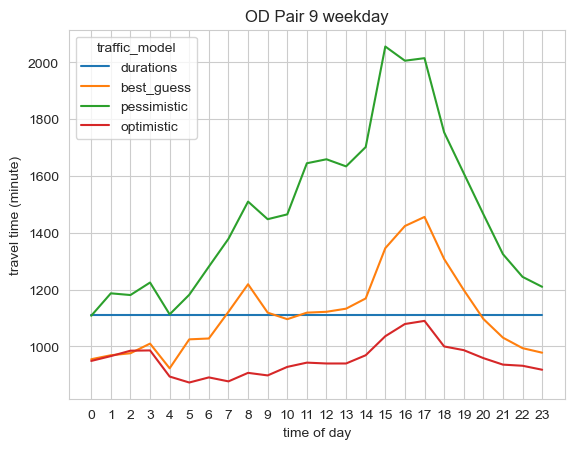

In [65]:
# visualize travel time throughout a weekday using different google API models
draw_travel_time_with_different_models(sample_duration_df[sample_duration_df['date'] == sample_weekday], ' weekday')

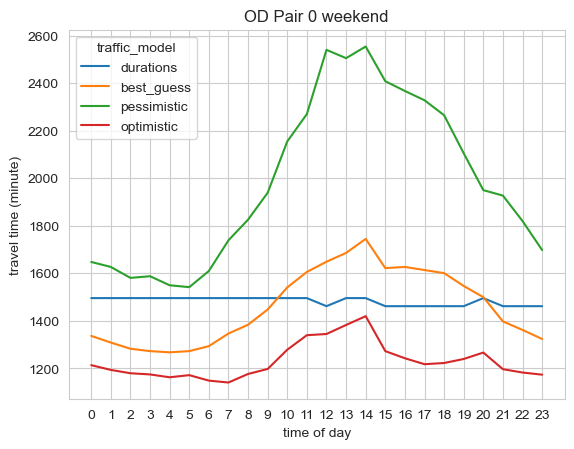

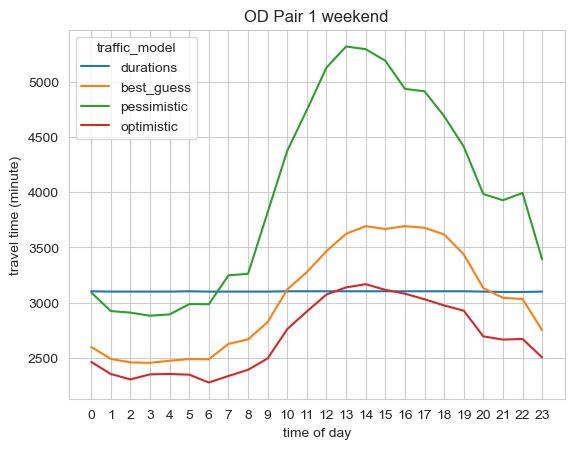

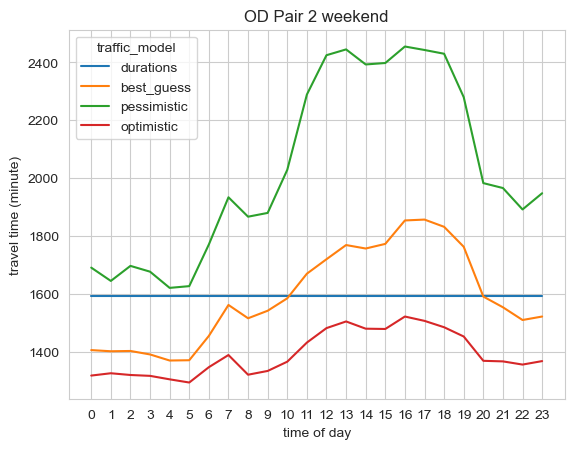

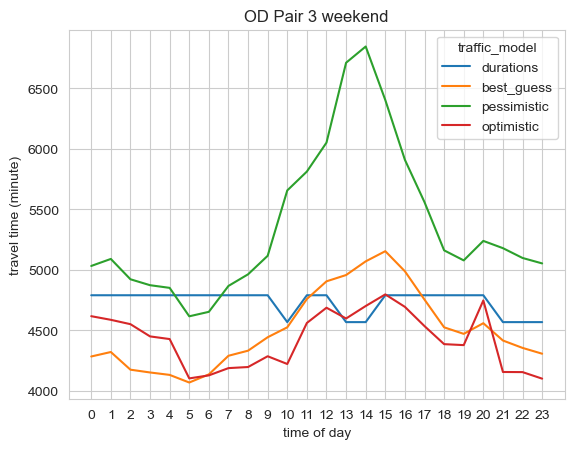

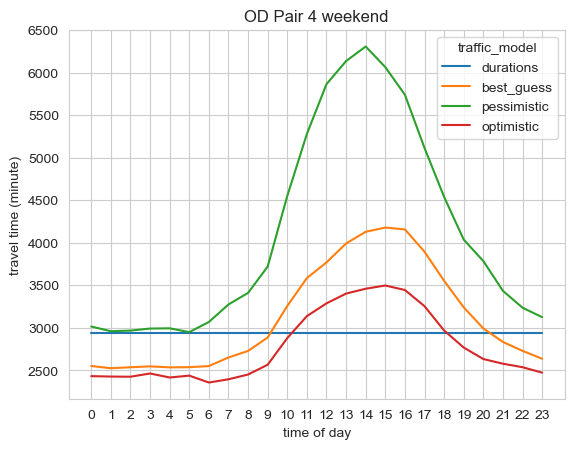

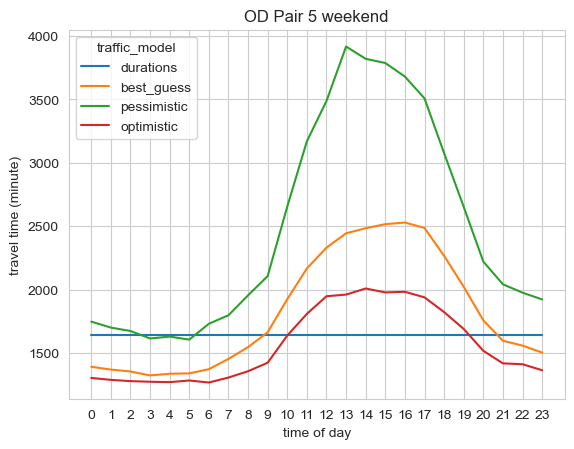

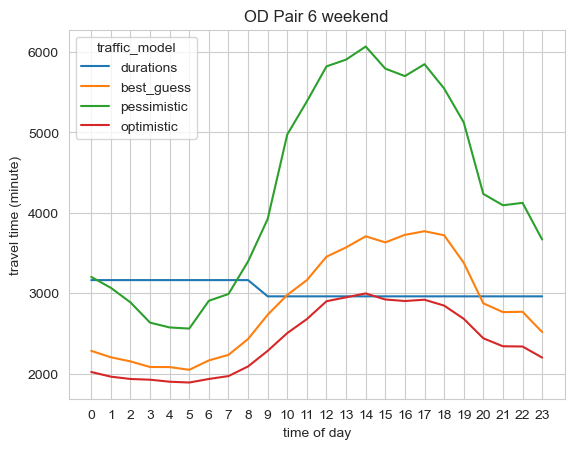

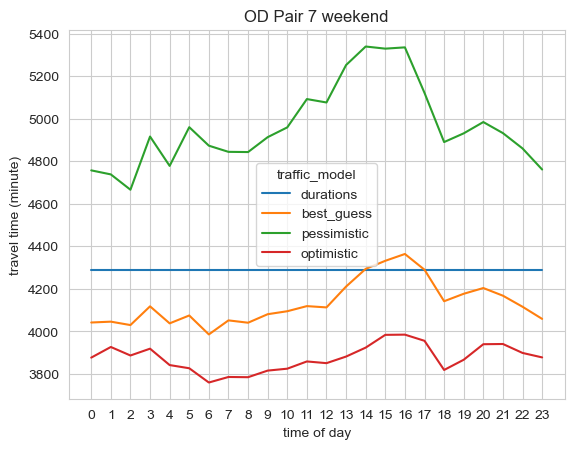

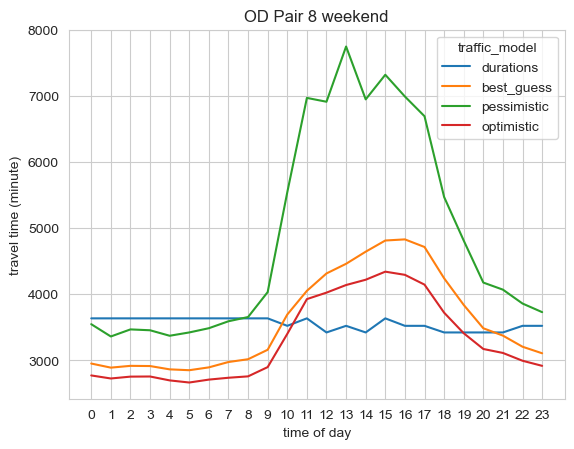

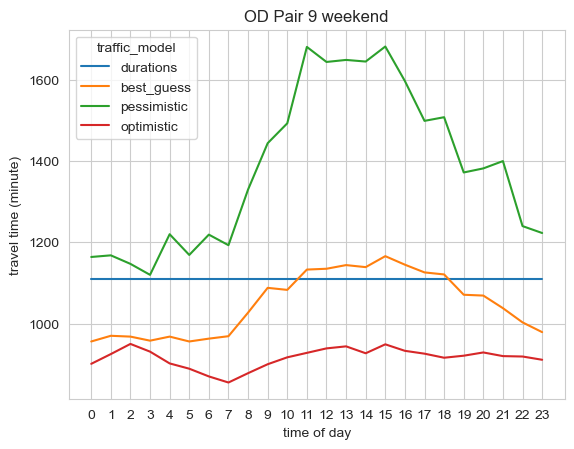

In [49]:
draw_travel_time_with_different_models(sample_duration_df[sample_duration_df['date'] == sample_weekend], ' weekend')

## Visualization between google travel time and our model result (traffic impediment and incorporating turn penalty in the routing)

In [72]:
penalty_df = pd.read_csv(file_path + 'all_penalty_travel_time.csv', names=['od_pair', 'duration'])
penalty_df['traffic_model'] = 'penalty_model'
penalty_df = penalty_df.merge(pd.Series(range(24), name='day_hour'), how='cross')

In [102]:
duration_df = sample_duration_df.copy()
duration_df['weekday'] = sample_duration_df.apply(lambda row: 'weekday' if row['date'] == sample_weekday else 'weekend',
                                                  axis=1)
all_df = pd.concat([penalty_df, duration_df], axis=0)
all_df

,od_pair,duration,traffic_model,day_hour,date,weekday
0,0,1306.6,penalty_model,0,NaN,NaN
1,0,1306.6,penalty_model,1,NaN,NaN
2,0,1306.6,penalty_model,2,NaN,NaN
3,0,1306.6,penalty_model,3,NaN,NaN
4,0,1306.6,penalty_model,4,NaN,NaN
...,...,...,...,...,...,...
1915,5,1366.0,optimistic,23,2023-10-21,weekend
1916,6,2199.0,optimistic,23,2023-10-21,weekend
1917,7,3878.0,optimistic,23,2023-10-21,weekend
1918,8,2918.0,optimistic,23,2023-10-21,weekend


In [127]:
selected_df = all_df[all_df['traffic_model'].isin(['penalty_model', 'durations', 'best_guess'])].copy()

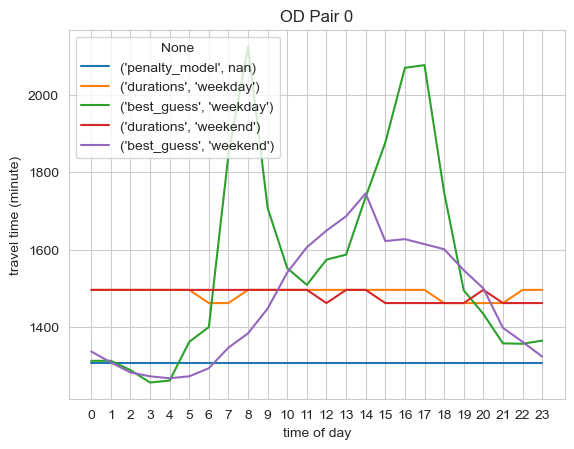

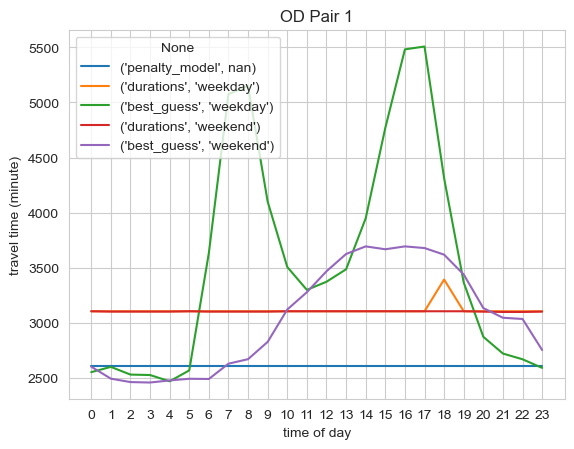

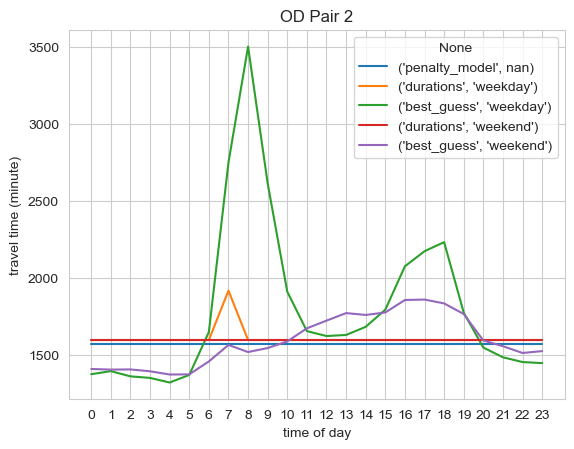

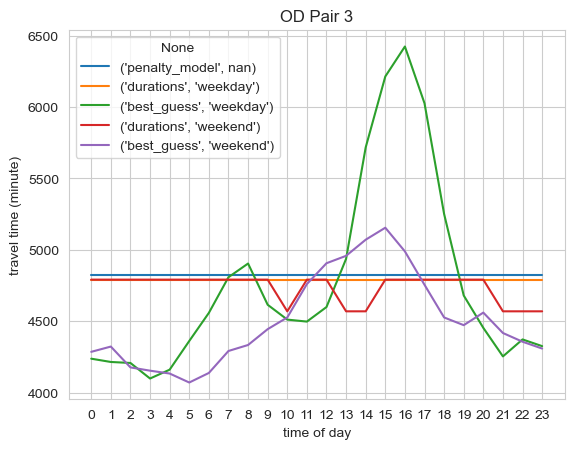

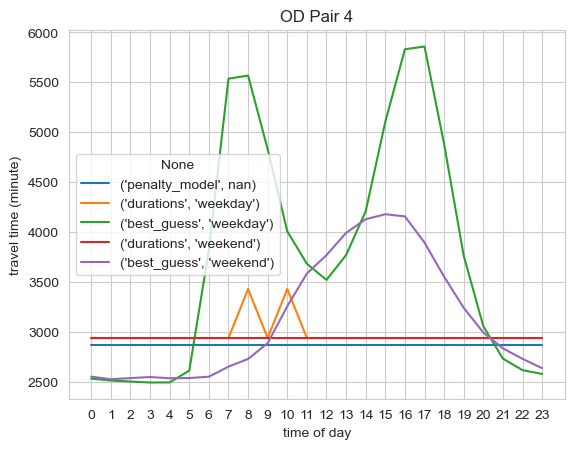

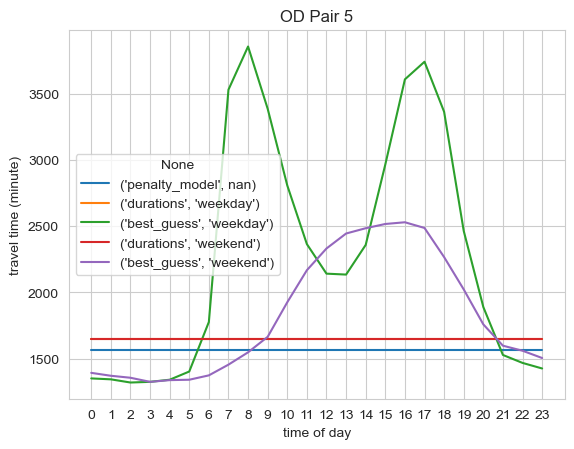

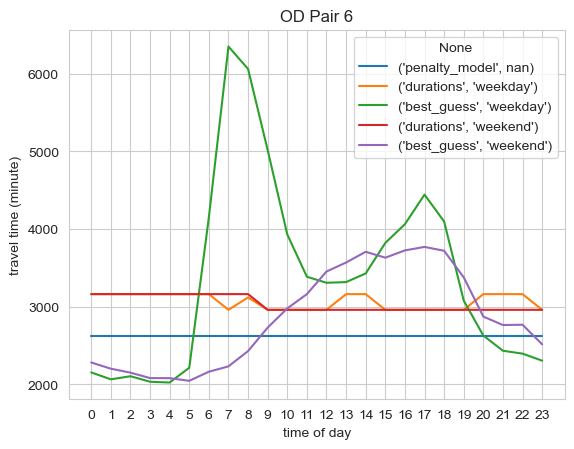

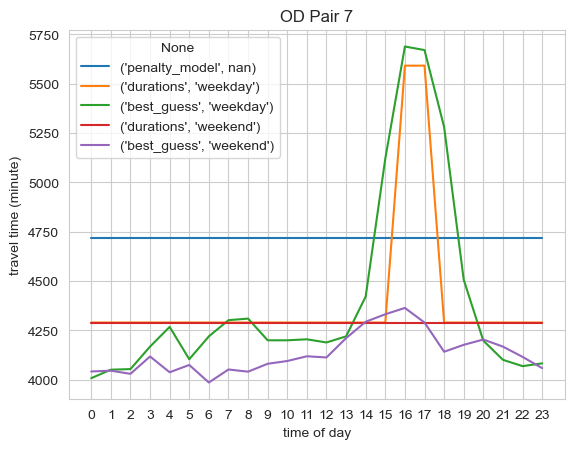

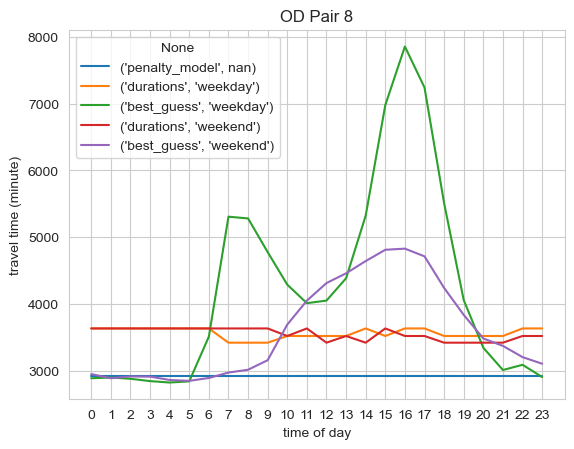

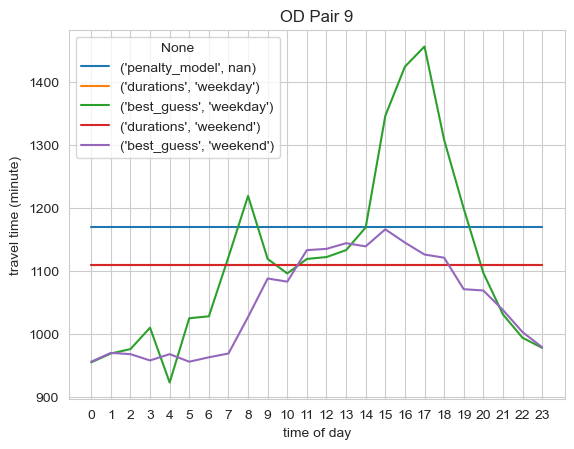

In [128]:
for od_pair_index in range(od_pair_count):
    df = selected_df[selected_df['od_pair'] == od_pair_index]
    fig = plt.figure()
    plt.xticks(range(24))
    ax = sns.lineplot(x='day_hour', y='duration', hue=df[['traffic_model', 'weekday']].apply(tuple, axis=1), data=df)
    ax.set_ylabel("travel time (minute)")
    ax.set_xlabel("time of day")
    ax.set_title(f'OD Pair {od_pair_index}')